In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from glob import glob
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
fname = 'goodData_QSwithTAO_with2hrStatsConv.nc'
ds = xr.open_dataset(fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
data = ds.to_dataframe()

In [3]:
import joblib
# # from sklearn.ensemble import RandomForestClassifier
# # # create RF
# # rf = RandomForestClassifier()
# # # fit on some data
# # rf.fit(X, y)

# # save
# joblib.dump(classifier, "random_forest_rainDetection.joblib")

# # load
classifier = joblib.load("random_forest_rainDetection.joblib")

In [4]:
# Features to use for classification
features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_RELH']

# Split the dataset into features (X) and target (y)
X = data[features]

y_pred = classifier.predict(X)


In [5]:
data['predicted_rain_flag'] = y_pred

In [6]:
df = data.copy()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

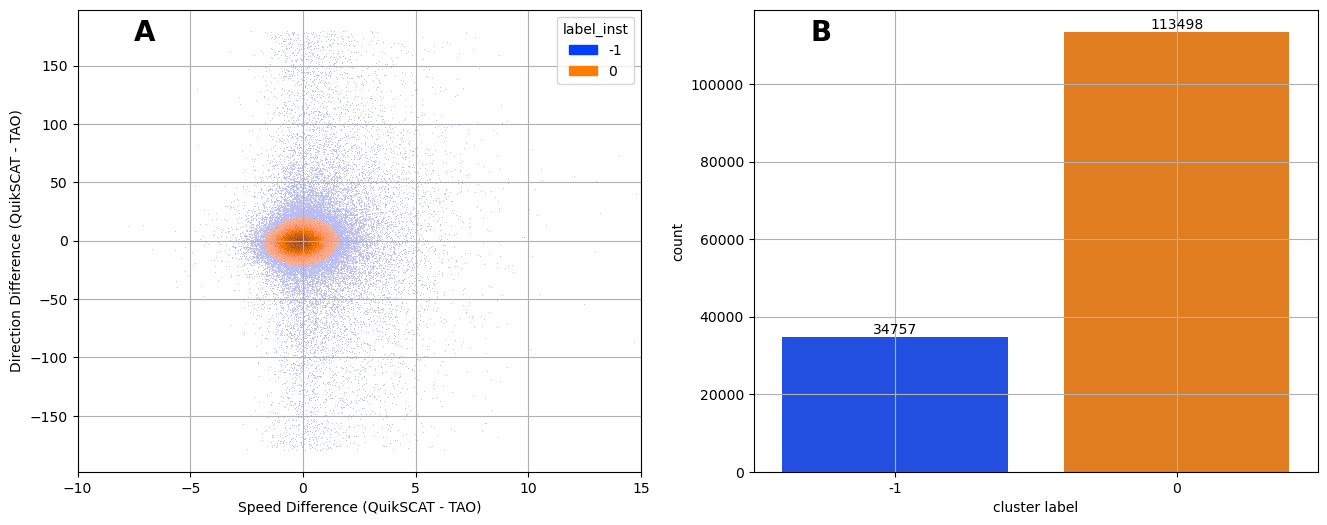

In [7]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label_inst'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label_inst', common_norm=True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label_inst',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

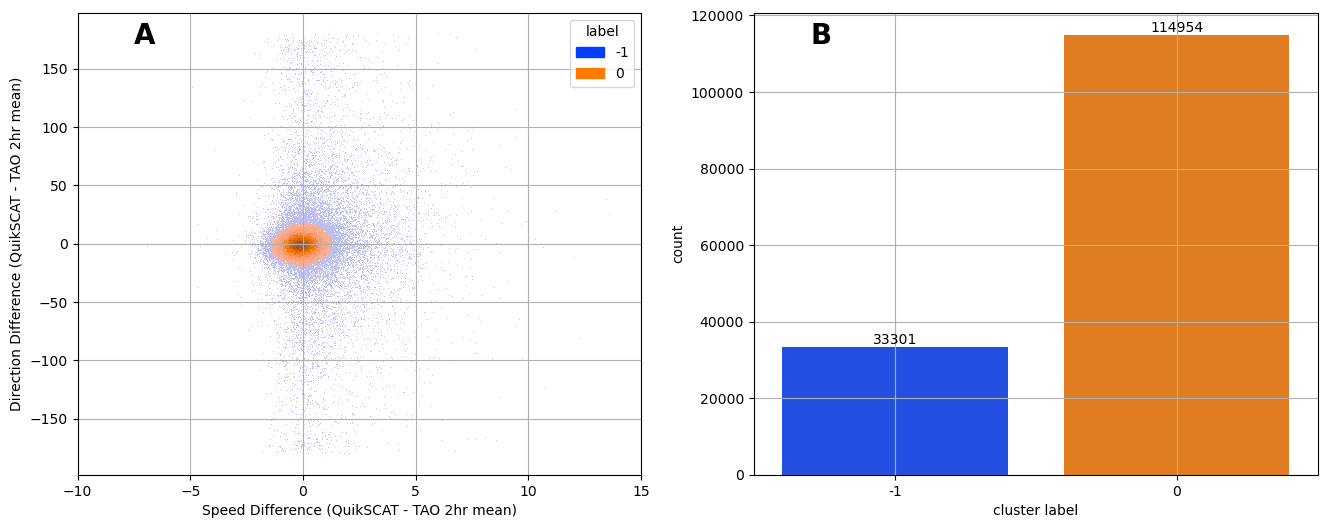

In [8]:
selectX = ['Speed Difference (QuikSCAT - TAO 2hr mean)',
          'cos(Direction Difference (QuikSCAT - TAO 2hr mean))',
          'sin(Direction Difference (QuikSCAT - TAO 2hr mean))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO 2hr mean)'
ylabel = 'Direction Difference (QuikSCAT - TAO 2hr mean)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [9]:
df

,Wind Direction (TAO),WDIR_QC,WDIR_DM,Wind Speed (TAO),WSPD_QC,WSPD_DM,Zonal Wind Speed (TAO),Meridional Wind Speed (TAO),Sea Surface Temperature (TAO),SST_QC,...,Wind Direction (TAO 2hr mean),Direction Difference (QuikSCAT - TAO 2hr mean),cos(Direction Difference (QuikSCAT - TAO 2hr mean)),Zonal Wind Speed Difference (QuikSCAT - TAO 2hr mean),Meridional Wind Speed Difference (QuikSCAT - TAO 2hr mean),sin(Direction Difference (QuikSCAT - TAO 2hr mean)),mean_WVEL,predicted_rain_flag,label_inst,label
count,,,,,,,,,,,,,,,,,,,,,
2,128.700012,2.0,b'D',5.04,2.0,b'D',-3.15,3.93,23.938000,2.0,...,130.078513,-3.790488,0.997812,0.291135,0.281640,-0.066108,6.071216,0,0,0
3,129.399994,2.0,b'D',5.46,2.0,b'D',-3.46,4.22,23.927999,2.0,...,130.264307,-3.429346,0.998209,0.180911,0.354617,-0.059818,5.974697,0,0,0
4,132.200012,2.0,b'D',5.52,2.0,b'D',-3.70,4.09,23.716999,2.0,...,133.751986,-2.042513,0.999365,-0.050234,0.363385,-0.035641,5.731566,0,0,0
5,97.899994,2.0,b'D',5.33,2.0,b'D',-0.74,5.27,23.789000,2.0,...,126.230910,-5.639784,0.995159,0.336265,0.625622,-0.098274,6.185240,0,-1,0
6,94.799988,2.0,b'D',5.00,2.0,b'D',-0.41,4.99,23.783001,2.0,...,126.069076,-4.569076,0.996822,0.262894,0.494374,-0.079661,6.056471,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184314,217.300003,2.0,b'D',6.46,2.0,b'D',-5.14,-3.91,26.746000,2.0,...,-154.538062,-6.467477,0.993636,-1.332021,0.496153,-0.112639,8.013899,0,-1,0
184315,216.000000,2.0,b'D',5.79,2.0,b'D',-4.68,-3.40,26.754999,2.0,...,-153.608184,-8.152940,0.989893,-0.961930,0.866649,-0.141816,7.926988,0,-1,0
184316,218.500000,2.0,b'D',9.70,2.0,b'D',-7.59,-6.04,26.757000,2.0,...,-144.904358,-4.736328,0.996585,-1.038358,0.414966,-0.082570,10.692351,0,0,0


In [10]:
classfied = df.to_xarray()

In [11]:
classfied

<xarray.Dataset>
Dimensions:                                                     (count: 148255)
Coordinates:
  * count                                                       (count) int64 ...
Data variables: (12/89)
    Wind Direction (TAO)                                        (count) float32 ...
    WDIR_QC                                                     (count) float32 ...
    WDIR_DM                                                     (count) object ...
    Wind Speed (TAO)                                            (count) float32 ...
    WSPD_QC                                                     (count) float32 ...
    WSPD_DM                                                     (count) object ...
    ...                                                          ...
    Meridional Wind Speed Difference (QuikSCAT - TAO 2hr mean)  (count) float64 ...
    sin(Direction Difference (QuikSCAT - TAO 2hr mean))         (count) float64 ...
    mean_WVEL                                                   (count) float64 ...
    predicted_rain_flag                                         (count) int64 ...
    label_inst                                                  (count) int64 ...
    label                                                       (count) int64 ...

In [12]:
classfied.to_netcdf('classified_data.nc')